# Lambda School Data Science Module 142
## Sampling, Confidence Intervals, and Hypothesis Testing

## Prepare - examine other available hypothesis tests

If you had to pick a single hypothesis test in your toolbox, t-test would probably be the best choice - but the good news is you don't have to pick just one! Here's some of the others to be aware of:

In [0]:
import numpy as np
from scipy.stats import chisquare  # One-way chi square test

# Chi square can take any crosstab/table and test the independence of rows/cols
# The null hypothesis is that the rows/cols are independent -> low chi square
# The alternative is that there is a dependence -> high chi square
# Be aware! Chi square does *not* tell you direction/causation

ind_obs = np.array([[1, 1], [2, 2]]).T
print(ind_obs)
print(chisquare(ind_obs, axis=None))

dep_obs = np.array([[16, 18, 16, 14, 12, 12], [32, 24, 16, 28, 20, 24]]).T
print(dep_obs)
print(chisquare(dep_obs, axis=None))

[[1 2]
 [1 2]]
Power_divergenceResult(statistic=0.6666666666666666, pvalue=0.8810148425137847)
[[16 32]
 [18 24]
 [16 16]
 [14 28]
 [12 20]
 [12 24]]
Power_divergenceResult(statistic=23.31034482758621, pvalue=0.015975692534127565)


In [0]:
# Distribution tests:
# We often assume that something is normal, but it can be important to *check*

# For example, later on with predictive modeling, a typical assumption is that
# residuals (prediction errors) are normal - checking is a good diagnostic

from scipy.stats import normaltest
# Poisson models arrival times and is related to the binomial (coinflip)
sample = np.random.poisson(5, 1000)
print(normaltest(sample))  # Pretty clearly not normal

NormaltestResult(statistic=38.69323106073592, pvalue=3.961609200867749e-09)


In [0]:
# Kruskal-Wallis H-test - compare the median rank between 2+ groups
# Can be applied to ranking decisions/outcomes/recommendations
# The underlying math comes from chi-square distribution, and is best for n>5
from scipy.stats import kruskal

x1 = [1, 3, 5, 7, 9]
y1 = [2, 4, 6, 8, 10]
print(kruskal(x1, y1))  # x1 is a little better, but not "significantly" so

x2 = [1, 1, 1]
y2 = [2, 2, 2]
z = [2, 2]  # Hey, a third group, and of different size!
print(kruskal(x2, y2, z))  # x clearly dominates

KruskalResult(statistic=0.2727272727272734, pvalue=0.6015081344405895)
KruskalResult(statistic=7.0, pvalue=0.0301973834223185)


And there's many more! `scipy.stats` is fairly comprehensive, though there are even more available if you delve into the extended world of statistics packages. As tests get increasingly obscure and specialized, the importance of knowing them by heart becomes small - but being able to look them up and figure them out when they *are* relevant is still important.

## Live Lecture - let's explore some more of scipy.stats

Candidate topics to explore:

- `scipy.stats.chi2` - the Chi-squared distribution, which we can use to reproduce the Chi-squared test
- Calculate the Chi-Squared test statistic "by hand" (with code), and feed it into `chi2`
- Build a confidence interval with `stats.t.ppf`, the t-distribution percentile point function (the inverse of the CDF) - we can write a function to return a tuple of `(mean, lower bound, upper bound)` that you can then use for the assignment (visualizing confidence intervals)

In [0]:
# Taking requests! Come to lecture with a topic or problem and we'll try it.

## Assignment - Build a confidence interval

A confidence interval refers to a neighborhood around some point estimate, the size of which is determined by the desired p-value. For instance, we might say that 52% of Americans prefer tacos to burritos, with a 95% confidence interval of +/- 5%.

52% (0.52) is the point estimate, and +/- 5% (the interval $[0.47, 0.57]$) is the confidence interval. "95% confidence" means a p-value $\leq 1 - 0.95 = 0.05$.

In this case, the confidence interval includes $0.5$ - which is the natural null hypothesis (that half of Americans prefer tacos and half burritos, thus there is no clear favorite). So in this case, we could use the confidence interval to report that we've failed to reject the null hypothesis.

But providing the full analysis with a confidence interval, including a graphical representation of it, can be a helpful and powerful way to tell your story. Done well, it is also more intuitive to a layperson than simply saying "fail to reject the null hypothesis" - it shows that in fact the data does *not* give a single clear result (the point estimate) but a whole range of possibilities.

How is a confidence interval built, and how should it be interpreted? It does *not* mean that 95% of the data lies in that interval - instead, the frequentist interpretation is "if we were to repeat this experiment 100 times, we would expect the average result to lie in this interval ~95 times."

For a 95% confidence interval and a normal(-ish) distribution, you can simply remember that +/-2 standard deviations contains 95% of the probability mass, and so the 95% confidence interval based on a given sample is centered at the mean (point estimate) and has a range of +/- 2 (or technically 1.96) standard deviations.

Different distributions/assumptions (90% confidence, 99% confidence) will require different math, but the overall process and interpretation (with a frequentist approach) will be the same.

Your assignment - using the data from the prior module ([congressional voting records](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records)):

1. Generate and numerically represent a confidence interval
2. Graphically (with a plot) represent the confidence interval
3. Interpret the confidence interval - what does it tell you about the data and its distribution?

Stretch goals:

1. Write a summary of your findings, mixing prose and math/code/results. *Note* - yes, this is by definition a political topic. It is challenging but important to keep your writing voice *neutral* and stick to the facts of the data. Data science often involves considering controversial issues, so it's important to be sensitive about them (especially if you want to publish).
2. Apply the techniques you learned today to your project data or other data of your choice, and write/discuss your findings here.
3. Refactor your code so it is elegant, readable, and can be easily run for all issues.

In [2]:
! pip install --upgrade Cython
! pip install --upgrade git+https://github.com/statsmodels/statsmodels


     |████████████████████████████████| 2.1MB 2.8MB/s 
  Found existing installation: Cython 0.29.7
    Uninstalling Cython-0.29.7:
      Successfully uninstalled Cython-0.29.7
  Cloning https://github.com/statsmodels/statsmodels to /tmp/pip-req-build-vlfj_eo1
  Running command git clone -q https://github.com/statsmodels/statsmodels /tmp/pip-req-build-vlfj_eo1
  Stored in directory: /tmp/pip-ephem-wheel-cache-ru8fc_jq/wheels/7d/ad/45/ac1a03bd759c2fa74c486e2b1950d94b55f511b4c2b0418bd5
Successfully built statsmodels
  Found existing installation: statsmodels 0.9.0
    Uninstalling statsmodels-0.9.0:
      Successfully uninstalled statsmodels-0.9.0


In [0]:
# TODO - your code!
import pandas as pd
import numpy as np, statsmodels.stats.api as sms
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
from scipy.stats import ttest_ind, ttest_ind_from_stats, ttest_rel


style.use('fivethirtyeight')

data_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data'

col_names = ['affiliation', 'hand_inf', 'water_cost_share', 'adopt_bud_res',
            'phy_fee_freeze', 'el_sal_aid', 'relig_group_school', 
            'anti_sat_test_ban', 'aid_nic_con', 'mx_missle', 'immigration',
            'synfuels_corp_cut', 'edu_spd', 'spfnd_sue', 'crime', 
             'duty_free_exp', 'exp_admin_southafrica']

df = pd.read_csv(data_url, names = col_names, header = None, na_values = '?')
df = df.dropna()
df = df.replace(('y', 'n'), (1, 0))





In [262]:
combined_cm_df = pd.DataFrame()

for column in df.loc[:, df.columns != 'affiliation']:
  group0 = df[df['affiliation'] == 'democrat'][column]
  group1 = df[df['affiliation'] == 'republican'][column]
  cm = sms.CompareMeans(sms.DescrStatsW(group0),
                       sms.DescrStatsW(group1))
  cm_df = (pd.DataFrame(cm.summary(usevar = 'unequal'), 
                        columns = ['a', 'b', 'c', 'd', 'e', 'f', 'g'])
           .iloc[:, [1, 5, 6]])
  cm_df = cm_df.drop(cm_df.index[0])
  cm_df = cm_df.rename(columns = {'b': 'diff_mean', 'f': 'lower', 'g': 'upper'})
  cm_df['feature'] = column
  cm_df['feature'].astype(str)
  combined_cm_df = combined_cm_df.append(cm_df, ignore_index = True)

cols = ['diff_mean', 'lower', 'upper']
combined_cm_df[cols] = (combined_cm_df[cols].astype('str')
                        .apply(pd.to_numeric, errors = 'coerce'))
combined_cm_df['feature'] = combined_cm_df['feature'].str.replace('_', ' ')
combined_cm_df

,diff_mean,lower,upper,feature
0,0.3757,0.259,0.493,hand inf
1,-0.0206,-0.150,0.109,water cost share
2,0.6974,0.604,0.791,adopt bud res
3,-0.9424,-0.985,-0.900,phy fee freeze
4,-0.7521,-0.834,-0.670,el sal aid
5,-0.4268,-0.536,-0.318,relig group school
6,0.4976,0.385,0.611,anti sat test ban
7,0.6825,0.588,0.777,aid nic con
8,0.6514,0.554,0.749,mx missle
9,-0.0418,-0.171,0.088,immigration


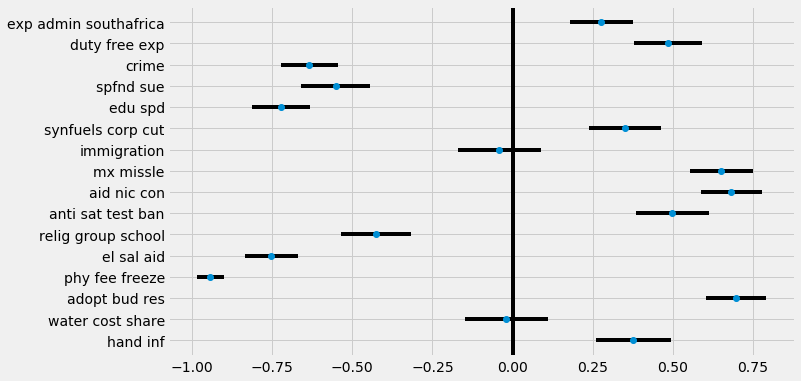

In [273]:
plt.figure(figsize = (10, 6))
plt.hlines(combined_cm_df['feature'], combined_cm_df['lower'], combined_cm_df['upper'])
plt.plot(combined_cm_df['diff_mean'], combined_cm_df['feature'], 'o')
plt.axvline(x = 0, c = 'black');


The chart above indicates the difference in mean values of political support for the noted features. 

A positive mean difference indicates more support from democrats, and a negative mean difference indicates more support from republicans. 

The black lines represent the confidence interval of the mean differences. Confidence intervals that cross at 0 indicate features that likely have support from both political parties.

## Resources

- [Interactive visualize the Chi-Squared test](https://homepage.divms.uiowa.edu/~mbognar/applets/chisq.html)
- [Calculation of Chi-Squared test statistic](https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test)
- [Visualization of a confidence interval generated by R code](https://commons.wikimedia.org/wiki/File:Confidence-interval.svg)
- [Expected value of a squared standard normal](https://math.stackexchange.com/questions/264061/expected-value-calculation-for-squared-normal-distribution) (it's 1 - which is why the expected value of a Chi-Squared with $n$ degrees of freedom is $n$, as it's the sum of $n$ squared standard normals)